# Data Analysis: YNAB Support Forums
- Sita Thomas
- NYCDSA Web Scraping Project
- July 2020
- Project Github repository: https://github.com/sitathomas/web_scraping_project

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Scraped-Data-Import" data-toc-modified-id="Scraped-Data-Import-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Scraped Data Import</a></span></li><li><span><a href="#Top-User-Ratios" data-toc-modified-id="Top-User-Ratios-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Top User Ratios</a></span></li><li><span><a href="#User-Lifespan" data-toc-modified-id="User-Lifespan-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>User Lifespan</a></span></li><li><span><a href="#Topic-Categories" data-toc-modified-id="Topic-Categories-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Topic Categories</a></span></li><li><span><a href="#Topic-Category-Graphs" data-toc-modified-id="Topic-Category-Graphs-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Topic Category Graphs</a></span></li><li><span><a href="#NLP-Pre-Processing" data-toc-modified-id="NLP-Pre-Processing-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>NLP Pre-Processing</a></span></li><li><span><a href="#Average-Stats" data-toc-modified-id="Average-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Average Stats</a></span></li><li><span><a href="#Top-Stats" data-toc-modified-id="Top-Stats-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Top Stats</a></span></li><li><span><a href="#Sentiment-Analysis" data-toc-modified-id="Sentiment-Analysis-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Sentiment Analysis</a></span></li><li><span><a href="#N-grams-Function" data-toc-modified-id="N-grams-Function-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>N-grams Function</a></span></li><li><span><a href="#Text-Bigrams-Word-Cloud" data-toc-modified-id="Text-Bigrams-Word-Cloud-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Text Bigrams Word Cloud</a></span></li><li><span><a href="#Title-Bigrams-Word-Cloud" data-toc-modified-id="Title-Bigrams-Word-Cloud-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Title Bigrams Word Cloud</a></span></li><li><span><a href="#Time-Series" data-toc-modified-id="Time-Series-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Time Series</a></span></li></ul></div>

## Setup

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer

from wordcloud import WordCloud
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from textblob import TextBlob

import plotly
import plotly.graph_objects as go
from plotly.graph_objs import Figure, Layout
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)

import datetime

## Scraped Data Import

In [2]:
ynab = pd.read_csv("ynab/ynab.csv")
ynab.posted = pd.to_datetime(ynab.posted)

ynab.head()

category  following  likes              posted  replies  \
0            Managing Debt        3.0      0 2020-02-08 12:50:00        2   
1          Getting Started        4.0      0 2020-02-13 09:29:00        3   
2  Accounts & Transactions        4.0      0 2020-02-16 11:00:00        6   
3             Credit Cards        2.0      0 2020-02-18 10:11:00        3   
4  Accounts & Transactions        2.0      0 2020-02-20 01:39:00        1   

                                                text  \
0  I have an all in one HELOC as my 1st mortgage ...   
1  Hey all - Newbie here. I am just getting start...   
2  I've just started YNAB and while i've had expe...   
3  Does YNAB offer private online tutorials where...   
4  Hello - I still can't import from my credit un...   

                                               title                 user  \
0          Northpoint Bank all in one checking/HELOC           davidebert   
1                                 Starting mid month              cardcat   
2  starting balances and transfers into account a...  Slate_Blue_Cleric.5   
3          Does YNAB offer private online tutorials?   Navy_Blue_Falcon.3   
4                                 Still can't import         Pink_Moose.4   

   views  
0     95  
1     85  
2     68  
3     69  
4     38

## Top User Ratios

In [3]:
print("Number of posts:", len(ynab))

print("Number of unique users:", len(set(ynab.user)))

print("Average posts per user:", round(len(ynab) / len(set(ynab.user)), 2))

posts_by_user = pd.DataFrame(ynab.groupby("user").size()).sort_values(0, ascending=False)
posts_by_user["user"] = posts_by_user.index
posts_by_user.index = range(0, len(posts_by_user))
posts_by_user.columns = ["posts", "user"]
posts_by_user["ratio"] = round(posts_by_user["posts"] / len(ynab), 3)
posts_by_user = posts_by_user[["user", "posts", "ratio"]]

posts_by_user[:10]

Number of posts: 7142
Number of unique users: 4629
Average posts per user: 1.54


user  posts  ratio
0            Khaki_Storm.1     64  0.009
1                    MXMOM     44  0.006
2  Tomato_Mask_05bd62cee89     42  0.006
3           Maroon_Admiral     29  0.004
4            Green_Nomad.7     26  0.004
5                 iwaddo77     25  0.004
6              Maroon_Mill     22  0.003
7          Sky_Blue_Harp.2     21  0.003
8            Salmon_Case.2     20  0.003
9        Turquoise_Major.5     19  0.003

## User Lifespan

In [100]:
lifespan = ynab.groupby(["user"], as_index=False).agg({"posted": ["min", "max"]})
lifespan.columns = lifespan.columns.to_flat_index()
lifespan.columns = ["user", "first_post", "last_post"]
lifespan["duration"] = lifespan.last_post - lifespan.first_post
lifespan = pd.merge(lifespan, posts_by_user, on="user")
lifespan

repeats_lifespan = lifespan.loc[lifespan.last_post > lifespan.first_post]
repeats_lifespan

user          first_post           last_post  \
0                 210mike 2018-12-10 12:46:00 2019-12-13 08:37:00   
2                  57Twin 2018-03-29 12:43:00 2018-04-05 02:55:00   
14    Alice_Blue_Camera.5 2020-02-04 12:29:00 2020-02-21 06:03:00   
15      Alice_Blue_Case.7 2019-06-30 01:23:00 2019-09-29 10:30:00   
16     Alice_Blue_Cello.2 2019-09-12 01:14:00 2019-09-19 12:43:00   
...                   ...                 ...                 ...   
4614           ynaber2613 2017-11-25 11:34:00 2019-09-20 06:03:00   
4616             ynabjess 2018-07-24 12:01:00 2018-11-04 07:18:00   
4619                 yort 2017-10-26 12:31:00 2017-11-17 08:48:00   
4620                zambo 2018-03-28 01:52:00 2018-05-07 12:46:00   
4621               zellie 2017-11-03 03:43:00 2019-07-05 04:33:00   

              duration  posts  ratio  
0    367 days 19:51:00      2    0.0  
2      6 days 14:12:00      3    0.0  
14    16 days 17:34:00      2    0.0  
15    91 days 09:07:00      2    0.0  
16     7 days 11:29:00      2    0.0  
...                ...    ...    ...  
4614 663 days 18:29:00      3    0.0  
4616 102 days 19:17:00      2    0.0  
4619  21 days 20:17:00      3    0.0  
4620  40 days 10:54:00      2    0.0  
4621 609 days 00:50:00      2    0.0  

[993 rows x 6 columns]

## Topic Categories

In [52]:
def build_cat_stats(field):
  return ynab.groupby("category")[field].sum()

category_stats = pd.concat([ynab.category.value_counts(), build_cat_stats("likes"),
                            build_cat_stats("replies"), build_cat_stats("views"),
                            build_cat_stats("following")], axis=1)
category_stats.columns.values[0] = "posts"
category_stats["category"] = category_stats.index
category_stats.index = range(0, len(category_stats))


def build_cat_ratios(field):
  category_stats["{}_ratio".format(field)] = 0
  new_cells = []
  for cell in category_stats[field]:
    new_cells.append(round(cell / category_stats[field].sum(), 3))
  category_stats["{}_ratio".format(field[0][0])] = new_cells

category_stats = pd.concat([category_stats, build_cat_ratios("posts"), build_cat_ratios("likes"),
                            build_cat_ratios("replies"), build_cat_ratios("views"),
                            build_cat_ratios("following")])
category_stats = category_stats[["category", "posts", "p_ratio", "likes", "l_ratio", "replies",
                                 "r_ratio", "views", "v_ratio", "following", "f_ratio"]]

category_stats

category  posts  p_ratio  likes  l_ratio  replies  r_ratio  \
0   Accounts & Transactions   1392    0.195    497    0.079     9657    0.153   
1        Method & Budgeting   1151    0.161    379    0.060    10459    0.166   
2             App Functions    847    0.119    928    0.147     7507    0.119   
3              Credit Cards    839    0.117    184    0.029     6651    0.105   
4           Getting Started    701    0.098    255    0.040     5298    0.084   
5             Tips & Tricks    558    0.078    542    0.086     5655    0.090   
6        API & Integrations    318    0.045    309    0.049     1676    0.027   
7                 YNAB Wins    294    0.041   2142    0.339     2488    0.039   
8             Managing Debt    276    0.039    182    0.029     2581    0.041   
9                    Saving    215    0.030    144    0.023     2252    0.036   
10   Investing & Retirement     95    0.013     67    0.011      939    0.015   
11    Money & Relationships     82    0.011     93    0.015      947    0.015   
12           Small Business     81    0.011     48    0.008      561    0.009   
13      Budgeting on Mobile     65    0.009     68    0.011      321    0.005   
14                Parenting     65    0.009     60    0.009      571    0.009   
15                     Debt     56    0.008     18    0.003      406    0.006   
16            Announcements     37    0.005    114    0.018      687    0.011   
17                Fun Money     27    0.004     14    0.002      205    0.003   
18             Student Life     21    0.003     13    0.002       99    0.002   
19     Community Challenges     21    0.003    261    0.041     4121    0.065   
20          Community Guide      1    0.000      0    0.000        0    0.000   

     views  v_ratio  following  f_ratio  
0   537632    0.142     5922.0    0.163  
1   575657    0.152     5962.0    0.164  
2   446094    0.118     4516.0    0.125  
3   377983    0.100     3692.0    0.102  
4   337325    0.089     3282.0    0.091  
5   416228    0.110     3426.0    0.094  
6   142260    0.038     1169.0    0.032  
7   179249    0.047     1380.0    0.038  
8   170791    0.045     1552.0    0.043  
9   141994    0.038     1297.0    0.036  
10   69748    0.018      558.0    0.015  
11   69933    0.019      583.0    0.016  
12   52765    0.014      419.0    0.012  
13   42418    0.011      290.0    0.008  
14   49633    0.013      408.0    0.011  
15   38629    0.010      266.0    0.007  
16   34077    0.009      463.0    0.013  
17   20472    0.005      151.0    0.004  
18    8268    0.002       74.0    0.002  
19   68384    0.018      851.0    0.023  
20     136    0.000        1.0    0.000

## Topic Category Graphs

In [7]:
fig = px.pie(category_stats, values='posts', names=list(category_stats.category), title='Posts Per Category')
fig.show()

In [8]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=category_stats.l_ratio.values,
    y=category_stats.category,
    name='Likes'
    )
)
fig.add_trace(go.Scatter(
    x=category_stats.r_ratio.values,
    y=category_stats.category,
    name='Replies'
    )
)
fig.add_trace(go.Scatter(
    x=category_stats.v_ratio.values,
    y=category_stats.category,
    name='Views'
    )
)
fig.add_trace(go.Scatter(
    x=category_stats.f_ratio.values,
    y=category_stats.category,
    name='Following'
    )
)

fig.update_traces(mode='markers', marker=dict(line_width=1, symbol='circle', size=16))

fig.update_layout(
    title="Post Interaction Ratios Per Category",
    xaxis=dict(
        ticks='outside',
    ),
    yaxis=dict(
        ticks='outside',
    )
)
fig.show()

The five categories with the highest number of posts also have the highest interaction ratios, with the exception of Likes - YNAB Wins has the highest ratio of Likes by a huge margin and 4/5 of the categories with the most posts each have a ratio of Likes lower than the other interaction ratios.

## NLP Pre-Processing

In [11]:
stop_words = stopwords.words('english') + \
    ["budget", "budgets", "budgeting", "budgeted", "ynab", "account", "accounts", "transaction",
     "transactions", "money", "category", "categories", "thank", "thanks", "make", "one", "way",
     "need", "want", "anyone", "know", "help", "question", "really", "still", "always", "hi",
     "hello", "thing", "http", "https", "www", "youneedabudget", "etc"]

def nlp_preprocess(field):
    # Clean text
    field = field.str.lower()
    field = field.apply(lambda x: re.sub('[^\w\s]', ' ', x))
    field = field.apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))

    # Lemmatize
    field = field.apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(word) for word in x.split()]))

    # Tokenize
    tokens = field.apply(lambda x: word_tokenize(x))
    field = tokens.apply(lambda x: " ".join(sorted(set(x), key=x.index)))
    return field
    

ynab.text = nlp_preprocess(ynab.text)
ynab.title = nlp_preprocess(ynab.title)

## Average Stats

In [9]:
def avg_stats(field):
  print("Average {}:".format(field), round(ynab.sort_values(field, ascending=False)[field].mean(), 2))
avg_stats("likes")
avg_stats("replies")
avg_stats("views")
avg_stats("following")

Average likes: 0.88
Average replies: 8.83
Average views: 529.22
Average following: 5.08


How can averages be increased? Do greater interactions per user indicate a longer relationship with the forums and therefore presumably a longer subscription?

## Top Stats

In [10]:
def top_stats(field):
  top_post = ynab.sort_values(field, ascending=False)
  print("Most {}:".format(field), top_post[field].iloc[0], "\n", top_post.iloc[0], "\n")
top_stats("likes")
top_stats("replies")
top_stats("views")
top_stats("following")

Most likes: 101 
 category                                  Community Challenges
following                                                  365
likes                                                      101
posted                                     2019-12-31 03:20:00
replies                                                   2575
text         Welcome to the Official* 2020 Debt Smackdown! ...
title                         The Official 2020 Debt Smackdown
user                                             BritishMuseum
views                                                     8947
Name: 6808, dtype: object 

Most replies: 2575 
 category                                  Community Challenges
following                                                  365
likes                                                      101
posted                                     2019-12-31 03:20:00
replies                                                   2575
text         Welcome to the Official* 2020 Debt Sma

## Sentiment Analysis

In [12]:
def sentiment_analysis(x):
    sentiment = TextBlob(x.text)
    x['polarity'] = sentiment.polarity
    x['subjectivity'] = sentiment.subjectivity
    return x

ynab_sa = ynab.apply(sentiment_analysis, axis=1)

fig = px.scatter(ynab_sa, x="polarity", y="likes")
fig.show()
fig = px.scatter(ynab_sa, x="polarity", y="replies")
fig.show()
fig = px.scatter(ynab_sa, x="polarity", y="views")
fig.show()
fig = px.scatter(ynab_sa, x="polarity", y="following")
fig.show()

fig = px.scatter(ynab_sa, x="subjectivity", y="likes")
fig.show()
fig = px.scatter(ynab_sa, x="subjectivity", y="replies")
fig.show()
fig = px.scatter(ynab_sa, x="subjectivity", y="views")
fig.show()
fig = px.scatter(ynab_sa, x="subjectivity", y="following")
fig.show()

Subjectivity isn't correlated with post interactions, but positive posts do tend to garner more interactions.

## N-grams Function

In [13]:
stop_bigrams = ["would_like", "would_nice", "even_though", "feel_like", "look_like", "go_back", "long_time",
                "started_using", "missing_something", "something_like", "something_wrong", "something_bad",
                "bad_happened", "text_think", "time_first", "would_love", "would_appreciated",
                "greatly_appreciated", "head_around", "get_back", "let_say", "can_not", "make_sense",
                "trying_figure", "trying_get", "thing_like", "seems_like", "e_g", "every_time",
                "using_year", "get_rid", "thought_would", "day_ago", "0_00", "1_2", "youneedabudget_com",
                "new_user", "brand_new", "using_since"]

def n_grams(field, n, stop_list):
    new_col = field.apply(lambda x: TextBlob(x).ngrams(n))
    new_col = new_col.apply(lambda x: ['_'.join(grams) for grams in x])
    new_col = new_col.apply(lambda x: ' '.join(x))
    new_col = new_col.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_list))
    ynab["{}_ngrams".format(field.name)] = new_col
    
n_grams(ynab.text, 2, stop_bigrams)
n_grams(ynab.title, 2, stop_bigrams)

## Text Bigrams Word Cloud

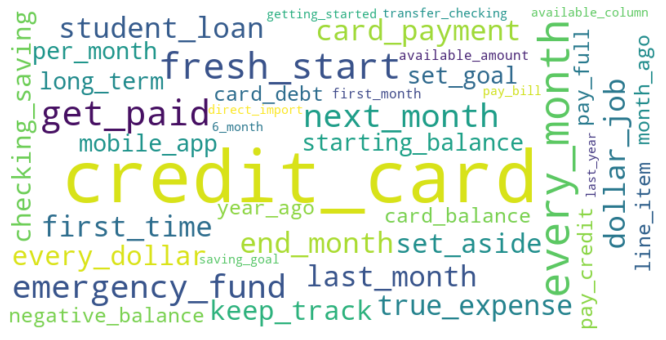

In [14]:
wc = WordCloud(background_color="white", max_words=40, width=800, height=400, collocations=False)

wc.generate(" ".join(ynab.text_ngrams))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

A lot of the posts seems to discuss credit cards - "credit card, card balance, card payment, card debt, pay credit, use credit." The word cloud indicates that credit cards are a popular source of discussion - marketing could be targeted toward people looking to manage their credit cards. It also potentially indicates that credit cards may be a source of confusion to users, and may be a software feature to improve.
 
Another common bigram is "fresh start," which is a feature of the YNAB software that users often utilize when they are confused by their budget or have a major life event that significantly alters their budget. Further text analysis, to explore why users implement Fresh Start, may be useful. If users Fresh Start mostly out of frustration, the risk of losing users may increase.

Other topics of interest indicated by the word cloud include emergency funds, student loans, True Expenses, and goals (set, monthly, saving). True Expenses are part of the YNAB methodology, and are usually bills that occur less than monthly. Goals are subjective user goals, but also a software feature. All of these topics can be areas for targeted marketing as well as educational content.

## Title Bigrams Word Cloud

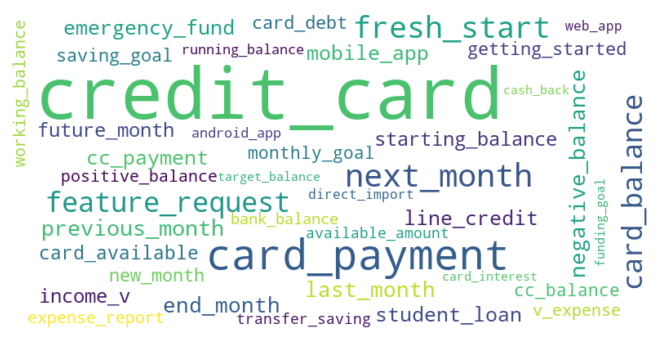

In [15]:
wc.generate(" ".join(ynab.title_ngrams))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Time Series

In [5]:
by_date = ynab.sort_values('posted', ascending=False)

print("Newest post date:", by_date.posted.iloc[0])
print("Oldest post date:", by_date.posted.iloc[-1])

Newest post date: 2020-06-17 12:47:00
Oldest post date: 2017-10-26 01:50:00


In [16]:
ynab["month"] = ynab.posted.dt.to_period("M")
ynab.month = ynab.month.apply(lambda x: x.to_timestamp())

posts_by_month = ynab.groupby("month").count()

fig = px.line(posts_by_month, x=posts_by_month.index, y="posted", title="Posts per Month")
fig.show()

Presumably, jumps from Nov/Dec to January are from posters discussing holiday expenses and/or New Year's Resolutions. The jump from April 2020 to May 2020 is noticeable and may be due to COVID-19 and its economic impacts.

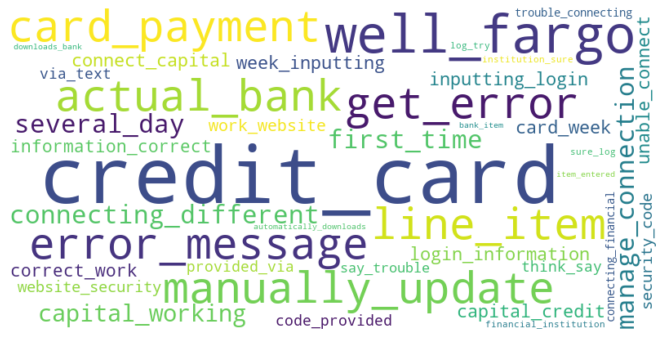

In [17]:
ynab_exp = pd.merge(ynab, category_stats[["category", "p_ratio", "l_ratio",
                                          "r_ratio", "v_ratio", "f_ratio"]], how="outer", on="category")
ynab_exp.loc[ynab_exp.month=="2020-04-01"].groupby("category").sum().sort_values("p_ratio", ascending=False)

wc.generate(' '.join(ynab.loc[(ynab.month=="2020-04-01") & \
                              (ynab.category=="Accounts & Transactions"),:].text_ngrams))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()